## Lesson 9: Introduction to deep learning

Readings:
- [Chapter 1](https://www.deeplearningbook.org/contents/intro.html)
- [Introduction to section II](https://www.deeplearningbook.org/contents/part_practical.html)
- [Introduction to chapter 6](https://www.deeplearningbook.org/contents/mlp.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()

from implements_09.scripts_09 import *

pi = np.pi

---

**Representations** are often necessary in order for a linear classification model to be able to separate a set of classes.
These representations are made by applying [nonlinear transformations](https://www.youtube.com/watch?v=kYB8IZa5AuE) to the data.

Take, for instance, the following dataset:

---

In [2]:
# Create a simple binary classification problem requiring nonlinear separation

N = 400
X = (np.random.random((N, 2))-0.5)*10
Y = probA_1(X[:, 0], X[:, 1])
labels = np.asarray(['A' if m else 'B' for m in np.random.random(Y.shape)<Y])

plot_points(X, labels, title='True labels');

---

Evidently, classes A and B are not [linearly separable](https://en.wikipedia.org/wiki/Linear_separability), and as such a linear 
classifier such as a linear [support vector machine](https://www.svm-tutorial.com/2017/02/svms-overview-support-vector-machines/) would be unable to succeed in a classification.

---

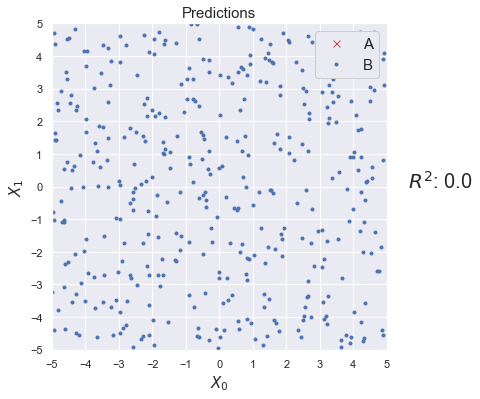

In [29]:
from sklearn import svm
# Here, we uset he sklearn implementation of the SVM classifier with a linear kernel
# build and train the model
SVM_classifier = svm.SVC(kernel='linear')
SVM_classifier.fit(X, labels)
predictions = SVM_classifier.predict(X)

plot_points(X, predictions, title='Predictions')

# add R squared to evaluate prediction quality
R2 = 1 - np.std(labels!=predictions)/np.std(labels=='A')
plt.gcf().text(0.95, 0.5, '$R^2$: '+str(R2), fontdict={'fontsize':20});

---

To classify these points using a linear model, we must create a an **intermediate representation** of the data such that a [hyperplane](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47) can separate classes A and B.

In this case, a [polar projection](https://en.wikipedia.org/wiki/Polar_coordinate_system) appears to be an appropriate representation. Let's try it out:

$R = \sqrt{X^2+Y^2}$

$\theta = arctan(\frac{Y}{X})$

---

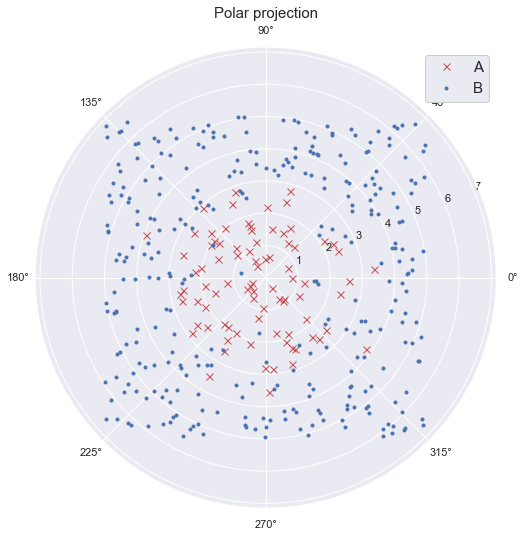

In [30]:
# Transform our coordinates from cartesian to polar

R = np.sqrt(X[:,0]**2 + X[:,1]**2)
ratio = X[:,1]/X[:,0]
THETA = np.arctan(ratio)+np.pi*(np.sign(X[:,0])<0)

X_radial = np.stack((THETA, R), axis=1)

plot_points(X_radial, labels, title='Polar projection', polar=True);

---

This projection allows us to clearly see that A and B are at least somewhat separable in the **radial** direction.

---

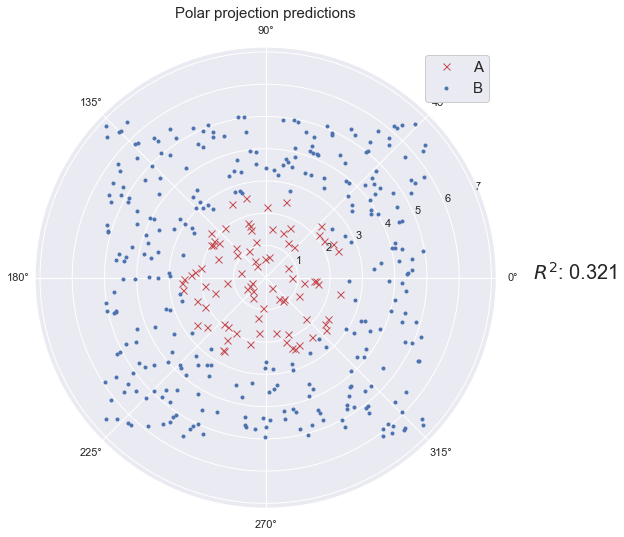

In [31]:
# Let's try the linear SVM classifier once more, on the polar projectionl
# build and train the model
SVM_classifier = svm.SVC(kernel='linear')
SVM_classifier.fit(X_radial, labels)
predictions = SVM_classifier.predict(X_radial)

ax = plot_points(np.stack((THETA, R), axis=1), predictions, title='Polar projection predictions', polar=True)

# add R squared to evaluate prediction quality
R2 = 1 - np.std(labels!=predictions)/np.std(labels=='A')
plt.gcf().text(0.95, 0.5, '$R^2$: '+str(round(R2,3)), fontdict={'fontsize':20});

---

Clearly, our predictions have vastly improved! Often it is difficult or even impossible to achieve perfect classification due to inherent [stochasticity](https://www.merriam-webster.com/dictionary/stochastic) of the data. This is one of those cases!

The **polar representation** has allowed our model to separate the two classes along the radial axis:

---

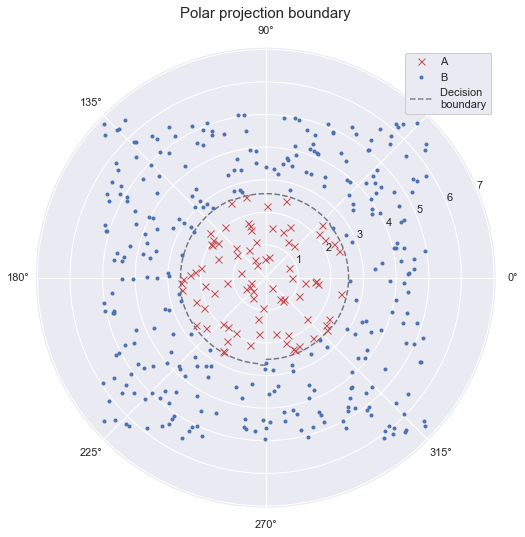

In [32]:
ax = plot_points(np.stack((THETA, R), axis=1), predictions, title='Polar projection boundary', polar=True)

weights = SVM_classifier.coef_[0]
intercept = SVM_classifier.intercept_[0]

# plot decision boundary
x0_mesh, x1_mesh = np.meshgrid(np.linspace(-pi/2, 3*pi/2, 200), np.linspace(0, 5*np.sqrt(2), 200))
pred_mesh = SVM_classifier.predict(np.stack((x0_mesh.flatten(), x1_mesh.flatten()), axis=1)).reshape(x0_mesh.shape)
pred_mesh_bool = pred_mesh=='A'
c1 = plt.contour(x0_mesh, x1_mesh, pred_mesh_bool, levels=[0.5], alpha=0.5, linestyles='--' )

# manually add decision boundary to legend
plt.plot([], [], 'k--', alpha=0.5, label='Decision \nboundary')
ax.legend(framealpha=1);

---

We can see that the decision boundary is a line nearly perpendicular to the $\theta$ axis. This is easier to see by plotting our polar coordinates in a cartesian graph:

---

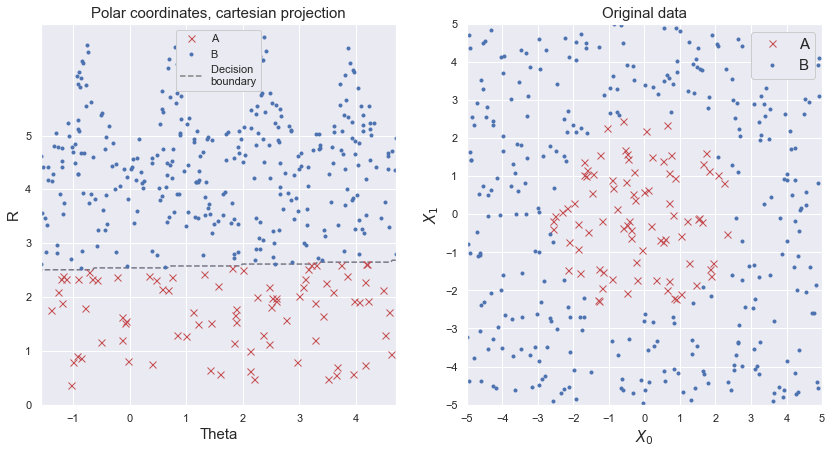

In [33]:
fig = plt.figure(figsize=(14,7))

ax = fig.add_subplot(121)

plot_points(np.stack((THETA, R), axis=1), predictions, title='Polar coordinates, cartesian projection', ax=ax)
ax.set_xlim(-pi/2, 3*pi/2)
ax.set_ylim(0, 5*2**0.5)

# plot decision boundary
c1 = ax.contour(x0_mesh, x1_mesh, pred_mesh_bool, levels=[0.5], alpha=0.5, linestyles='--' )
ax.set_xlabel('Theta')
ax.set_ylabel('R')

# manually add decision boundary to legend
ax.plot([], [], 'k--', alpha=0.5, label='Decision \nboundary')
ax.legend(framealpha=1);

ax2 = fig.add_subplot(122)
plot_points(X, predictions, title='Original data', ax=ax2)

---

For this problem, a hand-made polar representation conveniently made our classes linearly separable, but suppose you have a more complex distribution...

How easy would it be to design an alternative representation for the following dataset?

---

In [34]:
N = 400
X_2 = (np.random.random((N, 2))-0.5)*10
Y_2 = probA_2(X_2[:, 0], X_2[:, 1])
labels_2 = np.asarray(['A' if m else 'B' for m in np.random.random(Y_2.shape)<Y_2])


plot_points(X_2, labels_2, title='True labels');

---

Not easy at all!</br>
For this we turn once again to machine learning. What if our model could also **learn the intermediate representations** necessary for classification? This idea lies in the heart of deep learning.

While hand-designed representations are limited by the creativity and knowledge of the human who programs them, a machine is able to learn arbitrarily complex representations, as long as we give it the **capacity** to learn them.

We call these machine-learned representations **hidden representations**. This is because, since only the machine needs to process them, these representations do not need to be human-interpretable, and typically look like nonsense even to an expert.

We can take this idea one step further--if the machine will learn them anyways, why limit ourselves to only a single hidden representation?</br>
This is what gives "depth" to deep learning algorithms. We allow our model to learn many hidden representations, one after another, gradually transforming the data. If this is properly done, by the final transformation our output should be **linearly separable**.

Let's try this out!

--- 

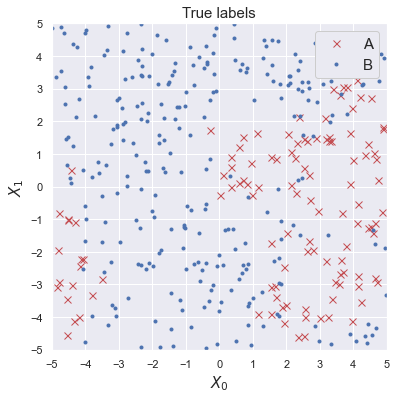

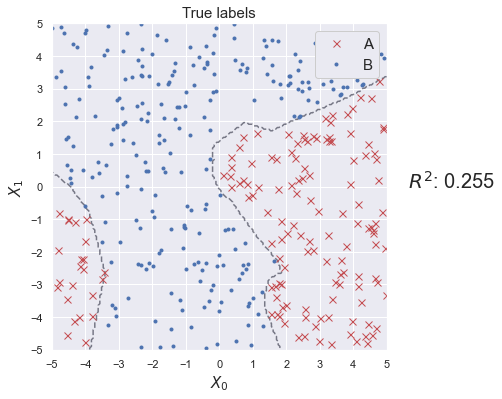

In [35]:
from sklearn import neural_network

# build neural net classifier
layers = (10, 10, 10,)
NN_classifier = neural_network.MLPClassifier(hidden_layer_sizes = layers,
                                             alpha = 0.1,
                                             learning_rate = 'constant',
                                             learning_rate_init = 0.01,
                                             max_iter = 800)

NN_classifier.fit(X_2, labels_2)
predictions = NN_classifier.predict(X_2)
plot_points(X_2, predictions, title='True labels');

# plot decision boundary
x0_mesh, x1_mesh = np.meshgrid(np.linspace(-5, 5, 200), np.linspace(-5, 5, 200))
pred_mesh = NN_classifier.predict(np.stack((x0_mesh.flatten(), x1_mesh.flatten()), axis=1)).reshape(x0_mesh.shape)
pred_mesh_bool = pred_mesh=='A'
c1 = plt.contour(x0_mesh, x1_mesh, pred_mesh_bool, levels=[0.5], alpha=0.5, linestyles='--' )

# add R squared to evaluate prediction quality
R2 = 1 - np.std(labels_2!=predictions)/np.std(labels_2=='A')
plt.gcf().text(0.95, 0.5, '$R^2$: '+str(round(R2,3)), fontdict={'fontsize':20});

# manually add decision boundary to legend
plt.plot([], [], 'k--', alpha=0.5, label='Decision \nboundary')
ax.legend(framealpha=1);

---

Pretty easy right?

Deep learning relies exclusively on a class of models called **[neural networks](https://www.youtube.com/watch?v=aircAruvnKk)** (I **strongly** recommend watching this series of videos).
These biologically-inspired models are made up of a network of **[artifical neurons](https://en.wikipedia.org/wiki/Artificial_neuron)**.
Each neuron applies a linear transformations to its inputs, followed by a simple nonlinear function, such as the [softmax function](https://medium.com/data-science-bootcamp/understand-the-softmax-function-in-minutes-f3a59641e86d).
While a single neuron is very simple and easy to model by hand, by stacking many layers of these neurons and chaining them together, very complex behavior can [emerge](https://theconversation.com/emergence-the-remarkable-simplicity-of-complexity-30973).

In the image below, each circle represents a single neuron, and each column of neurons is a layer in the neural network. The lines are connections between neurons, from the output of one to the input of the other

</br>
<img src="img/Neural network.png" />
</br>

---

---

The more layers a model has, the more complex the function its transformations can represent, and as such the more complex the problems it is able to solve.
Three layers may have been enough for the above problem, but deep machine vision networks may have hundreds of much larger layers, with millions and millions of parameters.

Deep neural networks have proven able to learn very complex problems, as long as they consist of mapping an input vector to an output vector, and can quickly be done by a human.
Other tasks that cannot be described as a vector mapping, or would take a human time to think and reflect upon, often prove beyond the scope of deep learning as of now.

---

---

Although neural networks were invented in the 1940s undet he name of cybernetics, its current popularity is relatively recent, traced back to Geoffrey Hinton's landmark work from 2006.
This can be attributed to two factors:
- Increasing dataset sizes
    - Driven by the digitization of society, larger datasets give us the resources necessary to train larger and more complex models.
- Increasing computational power
    - [More computational power](http://www.mooreslaw.org/) has allowed us to make larger and larger models. Many studies have shown that model size is the biggest contributor to its capacity, which allows us to use them for more and more complex tasks.

---

---

Nearly all machine learning involves an optimization process of some sort. This is the process of **learning** the data, where the model parameters change to better model the problem we would like to solve.

This is an optimization problem of the sort:

- Minimize **MODEL LOSS**
- Subject to **DATA**

Where the variables we optimize are the parameters of the model.

Some models are more complex than others. Let's compare them.

---

In [45]:
# The parameters of the SVM classifiers are its support vectors and coefficients

n_SVM = 0
n_SVM += np.multiply.reduce(SVM_classifier.support_vectors_.shape)
n_SVM += np.multiply.reduce(SVM_classifier.coef_.shape)
n_SVM += np.multiply.reduce(SVM_classifier.intercept_.shape)

print('The SVM classifier has {} parameters.'.format(n_SVM))

n_NN = 0
for layer in NN_classifier.coefs_:
    n_NN += np.multiply.reduce(layer.shape)
for layer in NN_classifier.intercepts_:
    n_NN += np.multiply.reduce(layer.shape)
    
print('The NN classifier has {} parameters.'.format(n_NN))

This SVM classifier has 179 parameters.
This NN classifier has 261 parameters.


---

That's a lot more parameters in the neural network!
As our we model harder and harder problems, we will need more and more complex representations, and so deeper and deeper models.
This quickly bloats our parameter count.

For reference, the groundbreaking [VGG16](https://arxiv.org/pdf/1409.1556.pdf) has a whopping **138 MILLION** parameters.

Assuming these are stored as 32-bit floats, thats 552MB just for parameter storage!
How are we supposed to optimize this insane 138M-dimensional space??

---

## Gradient descent

Imagine a ball on a hill.

<img src="implements_09/ball 01.PNG" width="350">

The ball cannot interact with and cannot "perceive" anything beyond the point of the hill that it is touching, and the forces that are exerted upon it.

<img src="implements_09/ball 04.PNG" width="350">

Nonetheless, if there is a valey surrounding this hill, the ball will roll down and stop **inside** the valley, even though it was outside its original "perception".

<img src="implements_09/ball 02.PNG" width="350">

This is the same principle we will apply here.
Our parameters are the position of the ball, and the hill topology is our loss function.
By limiting our perception of the optimization problem to the immediate vicinity of our current weights, we simplify the complexity of finding our way down the hill.

By taking small steps and repeating this process iteratively, we can follow quite complex curvatures in our loss curve, much as a ball will roll down a sloped track even if it has sharp curves.

<img src="implements_09/gradient_descent.png" width="550">

---

---

This optimization technique introduces several new **hyperparameters** into our model.
They are:
- **Learning rate**: how large a step our "ball" takes between iterations
- **Stop condition**: because of the very high dimensionality of our optimization problem, it is actually very unlikely we ever reach the "bottom" of our hill. Instead, we reach a point that is good enough. How this is determined is your choice. Typical stop conditions are stagnation of improvements, overfitting, and maximum iteration number.
- **Momentum**: We may decide that our "ball" should have some memory of its previous states between iterations in the form of speed. This parameter decides how much.
- **Others**: There are many variants of gradient descent such as SGD, Adam, and RMS. 

---